### 사용자 정의 지표

In [7]:
# data 준비
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers

# 교재에 있던 모델 생성 함수
def get_mnist_model():
    inputs = keras.Input(shape=(28 * 28,))
    features = layers.Dense(512, activation="relu")(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation="softmax")(features)
    model = keras.Model(inputs, outputs)
    return model

# 데이터 로드
(images, labels), (test_images, test_labels) = mnist.load_data()
# 데이터 전처리
images = images.reshape((60000, 28 * 28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28)).astype("float32") / 255
# train / test split
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

In [8]:
import tensorflow as tf
from tensorflow import keras

# custom metric
class MeanAbsoluteError(keras.metrics.Metric):
    def __init__(self, name="mae", **kwargs):
        super().__init__(name=name, **kwargs)
        self.mae_sum = self.add_weight(name="mae_sum", initializer="zeros")
        self.total_samples = self.add_weight(
            name="total_samples", initializer="zeros", dtype="int32")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        # 수정된 부분
        # sum of absolute of error
        mae = tf.reduce_sum(tf.abs(y_true - y_pred))

        self.mae_sum.assign_add(mae)
        num_samples = tf.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)

    def result(self):        
        return self.mae_sum / tf.cast(self.total_samples, tf.float32)
        

    def reset_state(self):
        self.mae_sum.assign(0.)
        self.total_samples.assign(0)

In [9]:
model = get_mnist_model()

model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', MeanAbsoluteError()])

model.fit(train_images, train_labels,
          epochs=3,
          validation_data = (val_images, val_labels))

test_metrics = model.evaluate(test_images, test_labels)

Epoch 1/3
1563/1563 [==============================] - 12s 7ms/step - loss: 0.2930 - accuracy: 0.9124 - mae: 56.0418 - val_loss: 0.1564 - val_accuracy: 0.9567 - val_mae: 56.0388
Epoch 2/3
1563/1563 [==============================] - 10s 6ms/step - loss: 0.1675 - accuracy: 0.9530 - mae: 55.9045 - val_loss: 0.1236 - val_accuracy: 0.9677 - val_mae: 56.0058
Epoch 3/3
313/313 [==============================] - 1s 2ms/step - loss: 0.1181 - accuracy: 0.9702 - mae: 56.1387


### 사용자 정의 콜백

In [15]:
from tensorflow import keras
from tensorflow.keras import layers

In [16]:
from tensorflow.keras.datasets import mnist

def get_mnist_model():
    inputs = keras.Input(shape=(28 * 28,))
    features = layers.Dense(512, activation="relu")(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation="softmax")(features)
    model = keras.Model(inputs, outputs)
    return model

(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28 * 28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28)).astype("float32") / 255
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

In [17]:
from matplotlib import pyplot as plt
import numpy as np

# loss 와 accuracy 를 출력하는 call back
class PlotLossAccuracy(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []
        self.per_batch_accuracy = []

    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get("loss"))
        self.per_batch_accuracy.append(logs.get("accuracy"))

    def on_epoch_end(self, epoch, logs):
        
        plt.plot(range(len(self.per_batch_losses)), self.per_batch_losses,
                 label="Training loss for each batch")
        plt.plot(range(len(self.per_batch_accuracy)), self.per_batch_accuracy,
                 label="Training accuracy for each batch")
        plt.xlabel(f"Batch (epoch {epoch})")
        plt.ylabel("Loss")
        self.per_batch_losses = []   
        self.per_batch_accuracy = []       
        plt.legend()
        # 교재와 다르게 저장하지 않고 바로 출력함.
        plt.show()
        
# validation loss 가 나아지지 않을 경우 조기 종료하는 callback
class CustomizedEarlyStopping(keras.callbacks.Callback):
    def __init__(self, patience=0):
        super().__init__()
        self.patience = patience
        self.stopped_epoch = 0
        self.best_weights = None
    
    def on_train_begin(self, logs):
        self.old_val_loss = np.Inf
        self.continued_epoch=0
    
    def on_epoch_end(self, epoch, logs):
        # logs 에서 validation loss 를 가져온다.
        val_loss = logs.get("val_loss")
        # 현재의 val_loss 와 과거의 val_loss 비교해서 현재가 더 클 경우
        if val_loss > self.old_val_loss:
            # continued epoch 이 증가 한다.
            self.continued_epoch+=1
            # patience 까지 정지 하지 않고 기다린다.
            if self.continued_epoch >= self.patience:
                # patience 이후에 중단한다.
                self.stopped_epoch = epoch
                self.model.stop_training = True
        else:
            # 현재의 val_loss 와 과거의 val_loss 비교해서 현재가 더 크지 않을 경우
            # 가중치를 저장하고, continued epoch 을 초기화 한다.
            self.best_weights = self.model.get_weights()
            self.continued_epoch=0
        # 현재의 loss 를 old_val_loss 에 저장한다.
        self.old_val_loss = val_loss
    
    def on_train_end(self, logs):
        if self.stopped_epoch > 0:
            print("Early stopping epoch: ", self.stopped_epoch + 1)

Epoch 1/8
1563/1563 [==============================] - 10s 6ms/step - loss: 0.2961 - accuracy: 0.9117 - val_loss: 0.1517 - val_accuracy: 0.9541


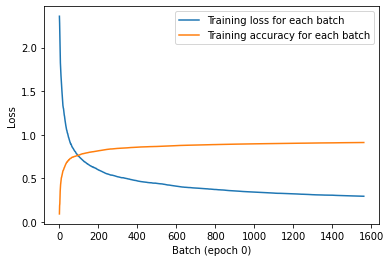

Epoch 2/8
1563/1563 [==============================] - 10s 6ms/step - loss: 0.1640 - accuracy: 0.9537 - val_loss: 0.1227 - val_accuracy: 0.9651


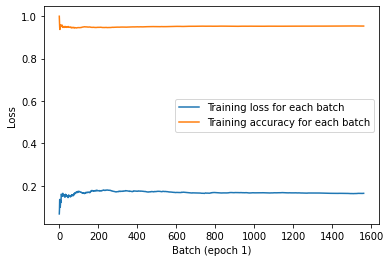

Epoch 3/8
1563/1563 [==============================] - 10s 6ms/step - loss: 0.1409 - accuracy: 0.9622 - val_loss: 0.1105 - val_accuracy: 0.9713


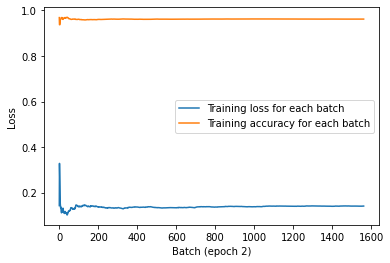

Epoch 4/8
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1279 - accuracy: 0.9671 - val_loss: 0.1137 - val_accuracy: 0.9726


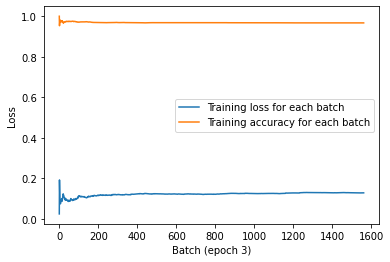

Early stopping epoch:  4


In [18]:
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
history = model.fit(train_images, train_labels,
          epochs=8,
          callbacks=[PlotLossAccuracy(), CustomizedEarlyStopping()],
          validation_data=(val_images, val_labels))

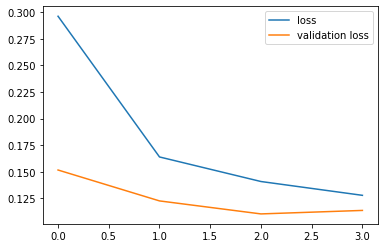

In [19]:
plt.plot(range(4), history.history['loss'], label='loss')
plt.plot(range(4), history.history['val_loss'], label='validation loss')
         
plt.legend()
plt.show()